In [35]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
%matplotlib notebook

# 0. Check stationarity, parity, conservation

Choose apropriate dynamics and evolution

### Frustrated Graph Creator

In [36]:
def frustrated_randomized_graph(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    

    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    
    return G

### Measure Frustration

In [37]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [38]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

In [39]:
def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    
    edge_colors=[]
    for i in a:
        if i==1:
            edge_colors.append("Green")
        else:
            edge_colors.append("Red")
    
    
    dic={}
    for e,value in zip(H.edges(),edge_colors):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'edge_color')
    
    return H

In [40]:
G = frustrated_randomized_graph(5,0.5)

### Properties

In [41]:
def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count(G))
    print("L-f: ",len(G.edges())-frustration_count(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count(G)/len(G.edges()))

# Rewiring Scheme

In [62]:
def Rewire(N,k):

    G = frustrated_randomized_graph(N,k)
    
    pos = nx.spring_layout(G, weight=None)
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')
    
    fig, ax = plt.subplots(figsize=(5,5))
    nx.draw(G,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)
    #Properties(G)

    a = frustration_count(G)
    
    #################################################################################################
    
    H = nx.algorithms.double_edge_swap(G.copy(), nswap=1)
    
    
    difference = list((set(set(sorted(G.edges())) ^ set(sorted(H.edges()))) - set(sorted(G.edges()))))
    
    nx.set_edge_attributes(H, {difference[0]:{'edge_color':"Blue"}})
    nx.set_edge_attributes(H, {difference[1]:{'edge_color':"Blue"}}) 
    
    #################################################################################################    
    
    #Properties(H)
    node_colors=nx.get_node_attributes(H,'color')
    edge_colors=nx.get_edge_attributes(H,'edge_color')
        
    fig, ax = plt.subplots(figsize=(5,5))
    nx.draw(H,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)
            
    b = frustration_count(H)
    
    if a == b:
        return 0
    if b > a:
        return 1
    if b < a:
        return -1

    print("end")

<IPython.core.display.Javascript object>


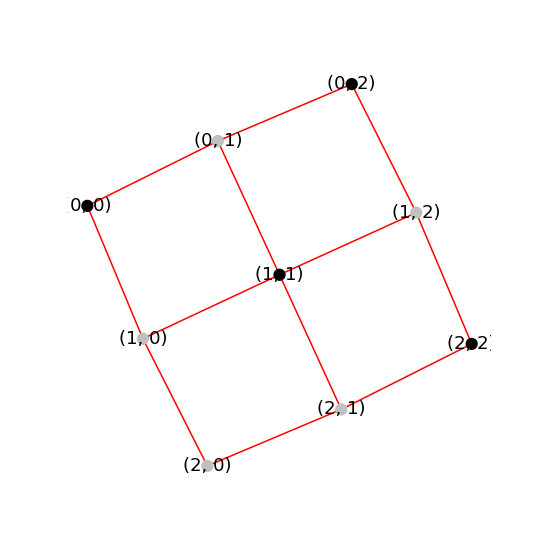

<IPython.core.display.Javascript object>


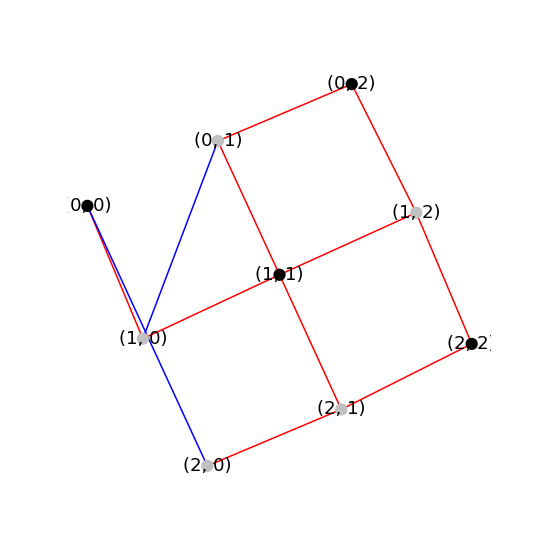

0

In [63]:
Rewire(3,0.5)

# 1. Calculate Expectation and Variance

### 2D Plot Graph

In [44]:
def Plot2D(G):

    pos =nx.get_node_attributes(G,'pos')
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    fig, ax = plt.subplots(figsize=(5,5))
    nx.draw(G,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)


<IPython.core.display.Javascript object>


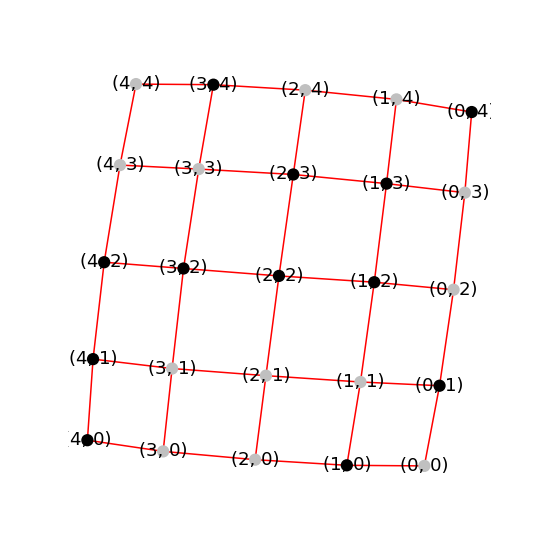

In [45]:
G = frustrated_randomized_graph(5,0.5)

Plot2D(G)

### 3D Plot Graph
https://networkx.org/documentation/stable/auto_examples/3d_drawing/plot_basic.html

In [50]:
def Plot3D(G,pos):
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # The graph to visualize
    #G = nx.cycle_graph(20)

    #pos = nx.spring_layout(G, weight=None)
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    # 3d spring layout
    #pos = nx.spring_layout(G, dim=3, seed=779)
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=100, ec="w",c=list(node_colors.values()))

    # Plot the edges
    for index, vizedge in enumerate(edge_xyz):
        ax.plot(*vizedge.T, color=list(edge_colors.values())[index])
        
    labels = list(G.nodes())

    for (x_label, y_label, z_label), label in zip((node_xyz), labels):
        ax.text(x_label, y_label, z_label, label,size='xx-small')


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


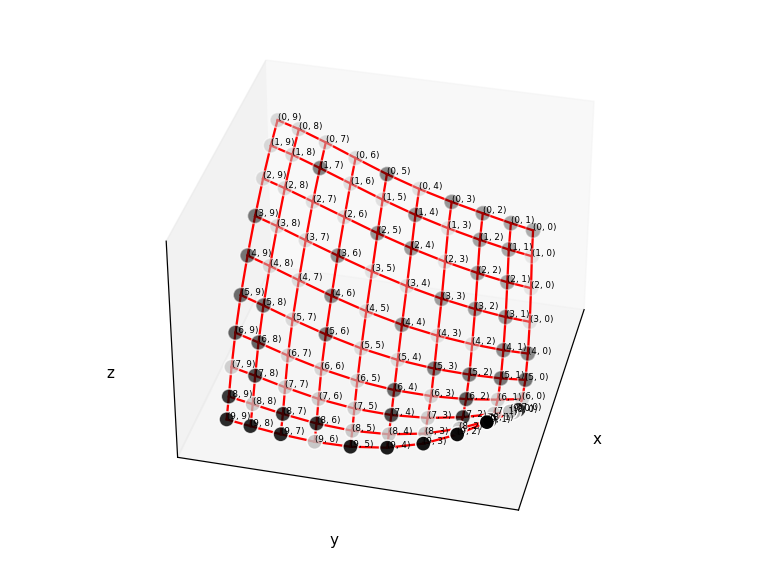

In [52]:
G = frustrated_randomized_graph(10,0.5)
pos = nx.spring_layout(G, dim=3)#, seed=779)

Plot3D(G,pos)

### Rewire 2

In [67]:
def Rewire2(N,k):

    G = frustrated_randomized_graph(N,k)
    
    #Plot2D(G)
    pos = nx.spring_layout(G, dim=3)
    Plot3D(G,pos)

    a = frustration_count(G)
    
    #################################################################################################
    
    H = nx.algorithms.double_edge_swap(G.copy(), nswap=1)
    
    difference = list((set(set(sorted(G.edges())) ^ set(sorted(H.edges()))) - set(sorted(G.edges()))))
    
    nx.set_edge_attributes(H, {difference[0]:{'edge_color':"Blue"}})
    nx.set_edge_attributes(H, {difference[1]:{'edge_color':"Blue"}}) 
    
    #################################################################################################    
    
    #Plot2D(H)
    Plot3D(H,pos)
    
    b = frustration_count(H)
    
    if a == b:
        return 0
    if b > a:
        return 1
    if b < a:
        return -1

    print("end")

<IPython.core.display.Javascript object>


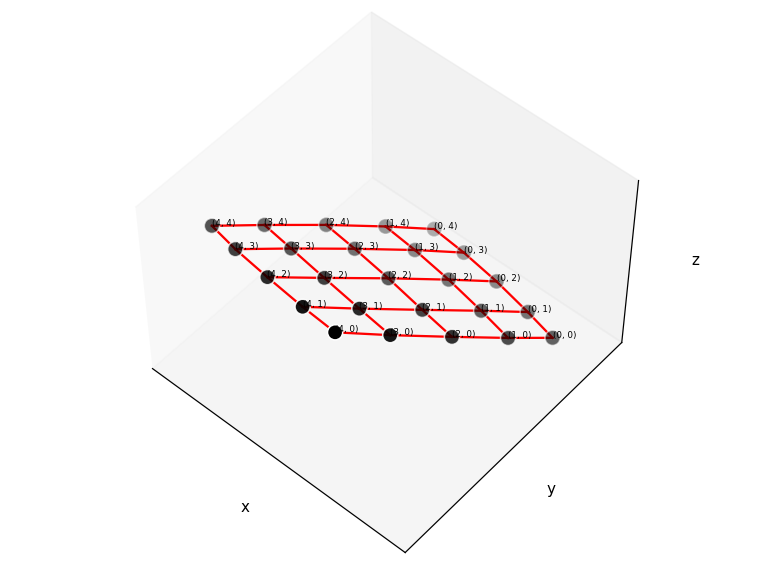

<IPython.core.display.Javascript object>


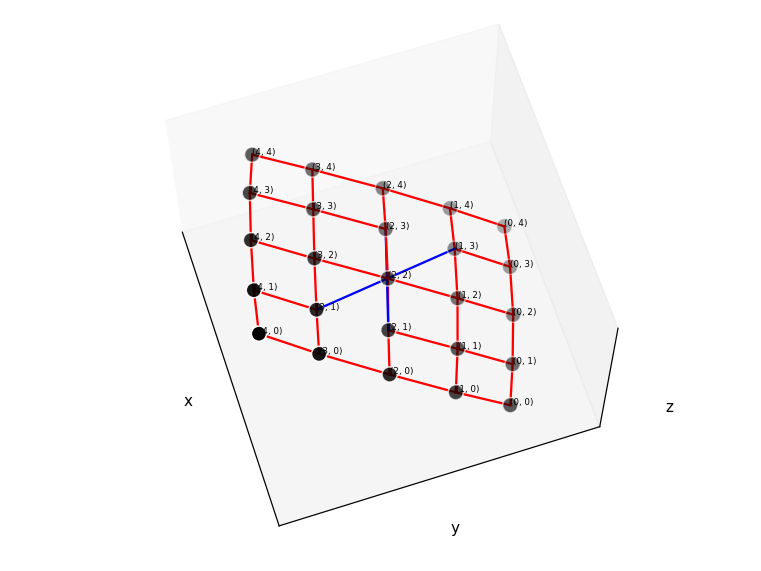

0

In [71]:
Rewire2(5,1.0)